# Project 1

Reddit is a social media forum on the internet.  Many "subreddits", forums dedicated to particular topics, make up the entirety of Reddit.  Users can pick and choose which subreddits will comprise their own Reddit, making them unique to each user.

The Stanford Network Analysis Project (SNAP) has [two datasets of Reddit's Hyperlink network](http://snap.stanford.edu/data/soc-RedditHyperlinks.html).  SNAP's datasets are concerned with Reddit posts that link to other subreddits.  Each entry has a source subreddit and a target subreddit along with a sentiment score (-1 for negative, and 1 for neutral/positive).  This is because some subreddits are created in response to other subreddits.  Utilizing the centrality measures, we can then determine which subreddits are most prone to being attacked, which do the most attacking, and the inverse.  Essentially, we can see which subreddits are popular enough to drive conversation around the rest of Reddit.

First, we'll load the data.

## Data Wrangling

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

title = pd.read_csv('soc-RedditHyperlinks-title.tsv', sep = '\t')
body = pd.read_csv('soc-RedditHyperlinks-body.tsv', sep = '\t')

Though a more indepth analysis can be done utilizing the `PROPERTIES` variable--allowing one to determine the number of characters, or average word length, or readability index--we will be mostly focusing on the sentiment between the `SOURCE_SUBREDDIT` and `TARGET_SUBREDDIT`.  For that, we'll drop the columns we won't be using, and merge the two dataframes together.

In [3]:
title = title.drop(['POST_ID', 'TIMESTAMP', 'PROPERTIES'], axis = 1)
body = body.drop(['POST_ID', 'TIMESTAMP', 'PROPERTIES'], axis = 1)
final = pd.concat([title, body])
final.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT
0,rddtgaming,rddtrust,1
1,xboxone,battlefield_4,1
2,ps4,battlefield_4,1
3,fitnesscirclejerk,leangains,1
4,fitnesscirclejerk,lifeprotips,1


## Visualization

Because there is a large amount of nodes, we took a sample of 2000 rows and added a 'color' column that resembles a categorical positive or negative sentiment by showing the edge in green or red respectively.

In [4]:
final['color'] = np.where(final['LINK_SENTIMENT']==1, 'g', 'r')
smallFinal = final.sample(n=2000, random_state=1)

Next we created an edgelist from the dataframe and made a directional graph from it.  Because the draw_networkx_edges function needs an array of strings, we made one from the 'colors' column. We then set the nodes positions using the spring layout.

In [5]:
final_graph = nx.from_pandas_edgelist(smallFinal, source='SOURCE_SUBREDDIT', 
                                      target='TARGET_SUBREDDIT',
                                      edge_attr='color',
                                      create_using = nx.DiGraph())

edges = final_graph.edges()
colors = [final_graph[u][v]['color'] for u,v in edges]

pos = nx.spring_layout(final_graph)

Finally, we set the figure size and plotted the graph. The arrows show the direction from source to target.

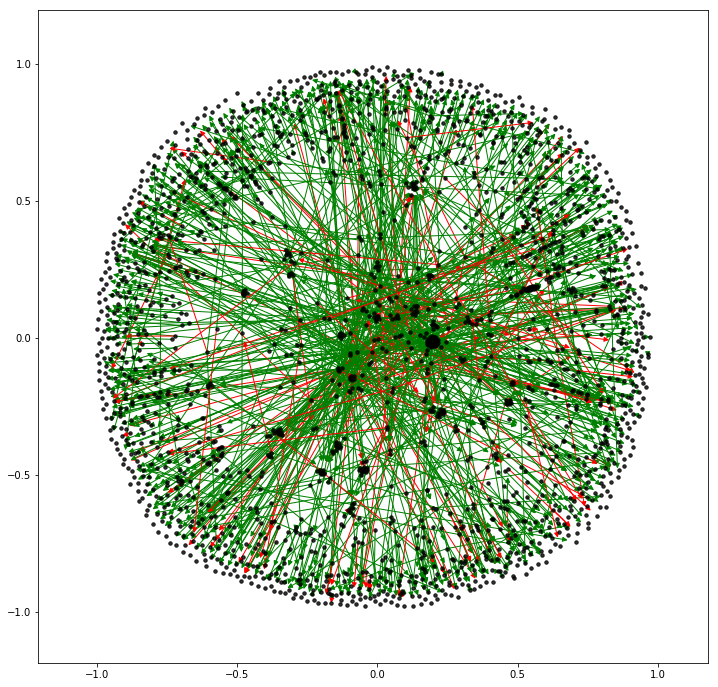

In [6]:
plt.figure(figsize = (12,12))
nx.draw_networkx_nodes(G=final_graph, pos=pos, node_list=final_graph.nodes(),
                       node_color='black', alpha=0.8, node_size=12)

nx.draw_networkx_edges(G=final_graph, pos=pos, edge_color=colors,
                       arrows=True)
plt.show()

The graph shows that many links seem to come from inside-out. This may be because the popular subreddits have more subscribers and link to other subreddits that vary widely to their personal tastes. The majority of the graph has a positive sentiment, while the negative sentiment links have a pattern without a clear, single cluster of origin. This pattern may hold more clues into the person than the post they link.  An example might be a person subscribed to the NFL subreddit and post a link to the 'TomBradyisOverrated' subreddit if he/she is actually a NY Giants fan. 

Now we'll split the dataframe between the `LINK_SENTIMENT` so that we can run centrality on those that have a positive/neutral connection, and those that have a negative connection.

In [4]:
good = final[final['LINK_SENTIMENT'] == 1]
bad = final[final['LINK_SENTIMENT'] != 1]

## Centrality

In [5]:
GG = nx.from_pandas_edgelist(good, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')
pCent = nx.degree_centrality(GG)
pc = pd.DataFrame.from_dict(pCent, orient = 'index', columns = ['Score'])
pc = pc.sort_values(by = 'Score', ascending = False)

NG = nx.from_pandas_edgelist(bad, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')
nCent = nx.degree_centrality(NG)
nc = pd.DataFrame.from_dict(nCent, orient = 'index', columns = ['Score'])
nc = nc.sort_values(by = 'Score', ascending = False)

print("Positive/Neutral Subreddit Centrality")
print(pc.head(10))
print("")
print("Negative Subreddit Centrality")
print(nc.head(10))

Positive/Neutral Subreddit Centrality
                   Score
askreddit       0.079783
iama            0.068264
pics            0.049445
bestof          0.047594
funny           0.046562
subredditdrama  0.045666
todayilearned   0.039914
videos          0.039429
titlegore       0.037638
gaming          0.031932

Negative Subreddit Centrality
                   Score
subredditdrama  0.160176
bestof          0.096371
askreddit       0.095210
drama           0.073832
funny           0.045161
todayilearned   0.042923
pics            0.041598
worldnews       0.041183
videos          0.039277
the_donald      0.037869


There is a lot of overlap between both categories, at least within the top 10.  Seven subreddits score high in both, although `subredditdrama` scores the highest with `0.16`.  Given the name, however, it's not surprising that it should be the recipient of a lot of negative attention.

In [6]:
peCent = nx.eigenvector_centrality(GG)
pe = pd.DataFrame.from_dict(peCent, orient = 'index', columns = ['Score'])
pe = pe.sort_values(by = 'Score', ascending = False)

neCent = nx.eigenvector_centrality(NG)
ne = pd.DataFrame.from_dict(neCent, orient = 'index', columns = ['Score'])
ne = ne.sort_values(by = 'Score', ascending = False)

print("Positive/Neutral Subreddit Eigenvector Centrality")
print(pe.head(10))
print("")
print("Negative Subreddit Eigenvector Centrality")
print(ne.head(10))

Positive/Neutral Subreddit Eigenvector Centrality
                   Score
askreddit       0.156323
iama            0.140738
bestof          0.139014
subredditdrama  0.136979
pics            0.125949
funny           0.124222
todayilearned   0.122006
videos          0.116535
titlegore       0.111079
gaming          0.092022

Negative Subreddit Eigenvector Centrality
                   Score
subredditdrama  0.243658
bestof          0.189298
askreddit       0.177516
drama           0.173328
todayilearned   0.127277
shitredditsays  0.116804
circlebroke2    0.116738
the_donald      0.115641
worldnews       0.115317
funny           0.115199


The eigenvector centralities share less subreddits than the regular centralities.  Only five subreddits are shared between the top 10.  Interestingly, however, the top ten for positive/neutral is nearly identical for both.  Only the ordering is different.  For the negative lists, 8 of the top ten are shared.

## Conclusion

We can see that the popular subreddits (`askreddit`, `bestof`, `subredditdrama`, `pics`, `funny`, `todayilearned`, `videos`) attract both positive and negative buzz throughout Reddit itself.  This is a good thing, as Reddit comes with a predefined list of subreddits a new user is automatically subscribed to.  Utilizing networks like this, they could potentially make that list much more dynamic.  In addition to subreddits that are simply popular, a new user could also ask to be subscribed to popular subreddits that are not controversial--that is subreddits that rank high on the positive/neutral, but lower in the negative--or vice versa.

Obviously moderators of each subreddit could utilize these networks to see where a lot of negative linkage is coming from, because this occasionally results in invasions, where the users of one subreddit will swarm another en masse to downvote the users/posts of the other subreddit.  Indeed, it would be interesting to see how many of these links were calling for just such an action.  The moderators could then be provided with tools to better protect themselves, so that the flow of their daily usage is not interrupted.